# Precicting House Prices with XGBoost

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [2]:
# Read the data
X = pd.read_csv('C:\\Users\\pedro.allegro\\Documents\\Code\\Code\\XGBoost\\train.csv', index_col='Id')
X_test_full = pd.read_csv('C:\\Users\\pedro.allegro\\Documents\\Code\\Code\\XGBoost\\\\test.csv', index_col='Id')

In [3]:
# Print the data
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Exploration

In [4]:
#find the categorical variables
categorical = [var for var in X.columns if X[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [5]:
# find the numerical variables
numerical = [var for var in X.columns if X[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 37 numerical variables


In [6]:
# find the discrete variables
discrete = []
for var in numerical:
    if len(X[var].unique())<20:
        print(var, ' values: ', X[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 15 discrete variables


In [7]:
# let's visualise the percentage of missing values
for var in X.columns:
    if X[var].isnull().sum()>0:
        print(var, X[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


There are a few variables that contain missing information (NaN). Some of them contain a lot of missing values, and some of them only a few. Let's first identify those that contain a lot of NaN and then see how we can process the different variables.

In [8]:
# let's inspect the type of those variables with a lot of missing information
for var in X.columns:
    if X[var].isnull().mean()>0.80:
        print(var, X[var].unique())

Alley [nan 'Grvl' 'Pave']
PoolQC [nan 'Ex' 'Fa' 'Gd']
Fence [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature [nan 'Shed' 'Gar2' 'Othr' 'TenC']


The ones with high percentage of missing data are categorical variables. We will need to fill those out (later).

<b>Outliers</b>
Let's find out now if the variables contain outliers.

In [9]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice']]
continuous

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

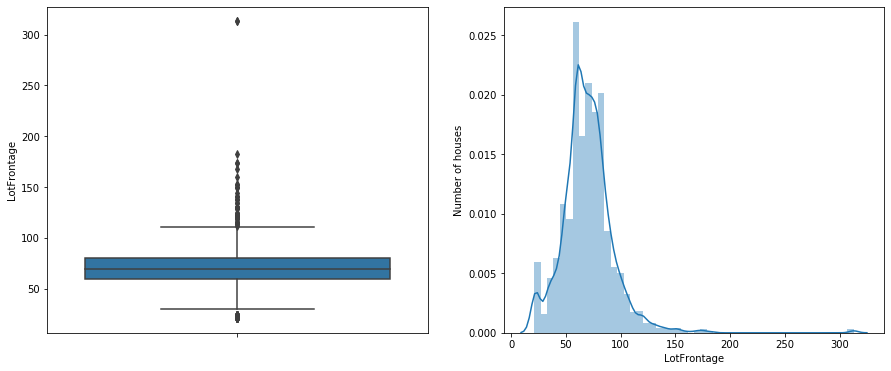

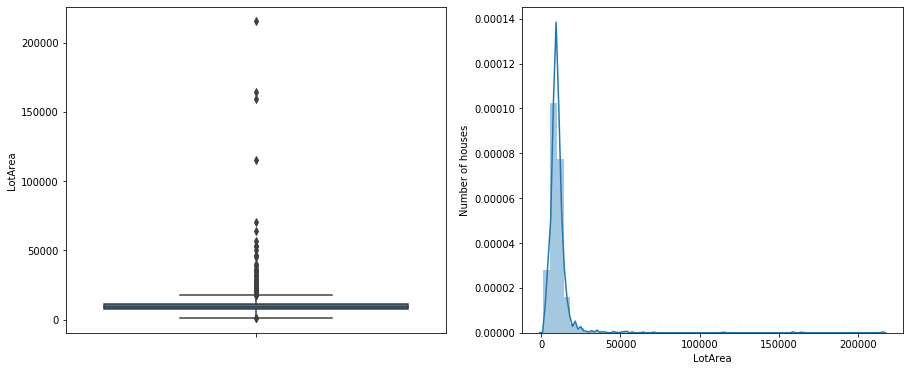

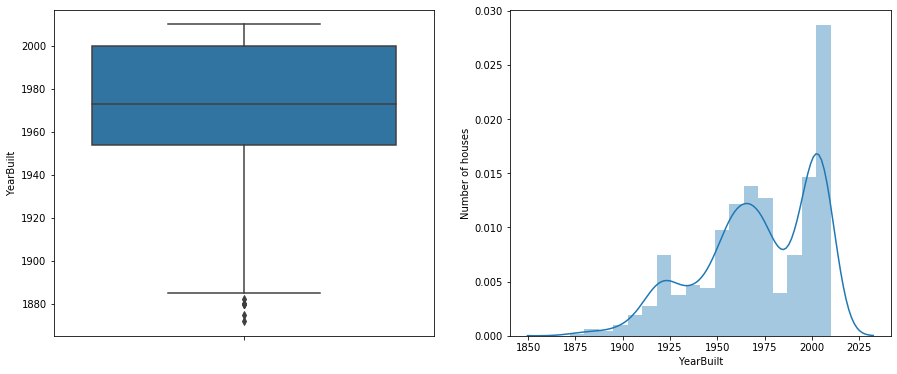

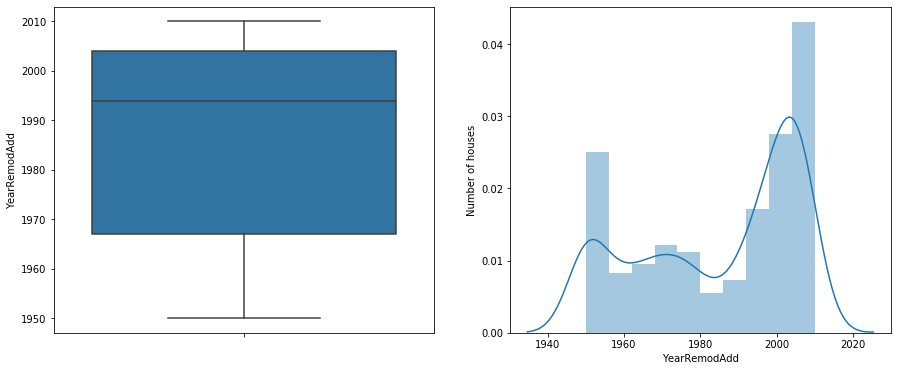

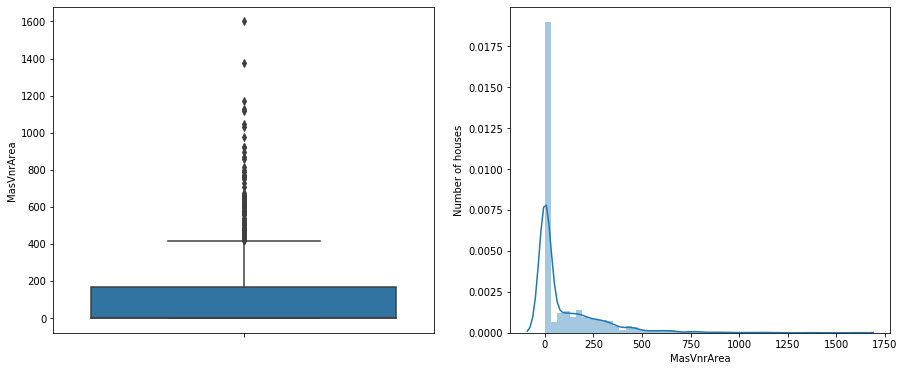

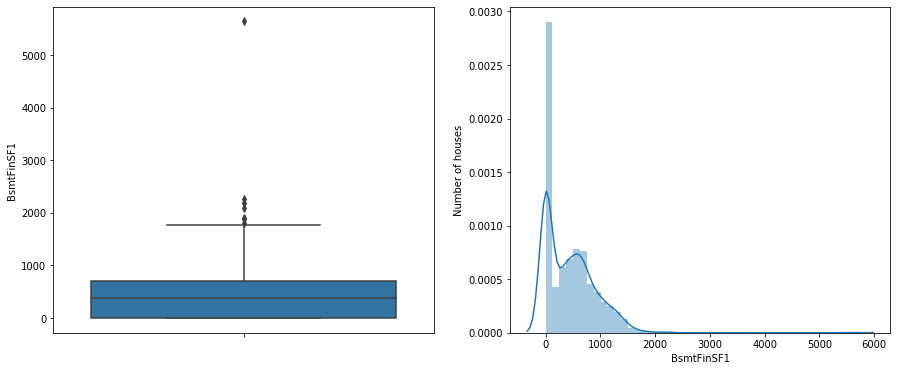

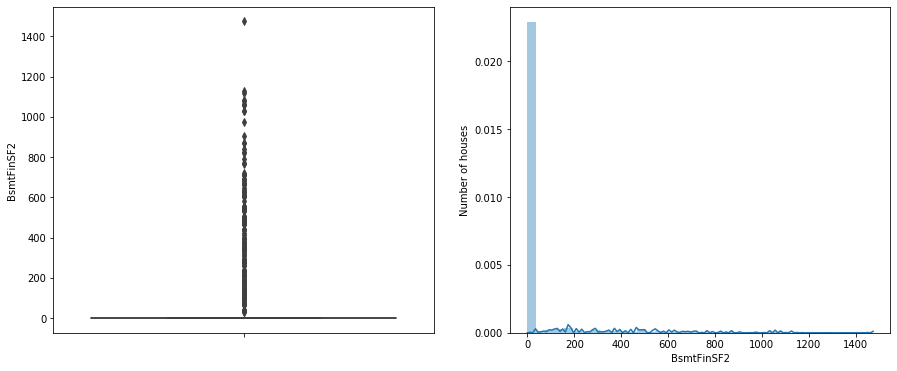

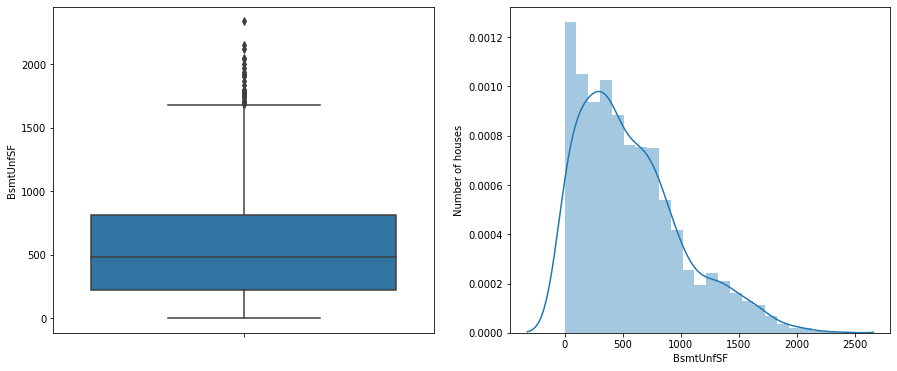

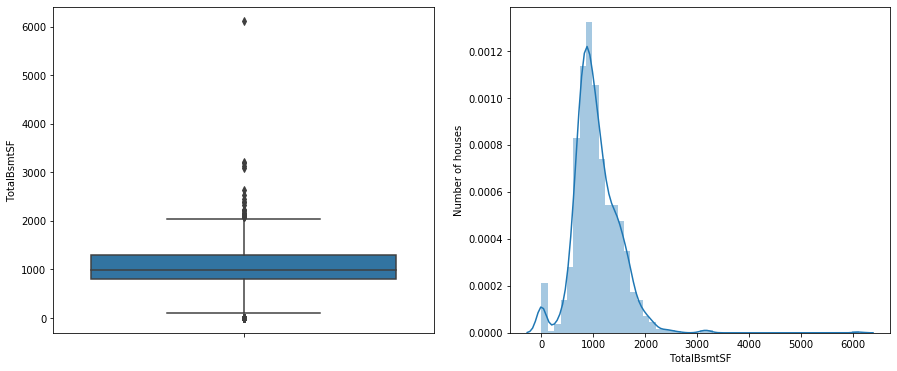

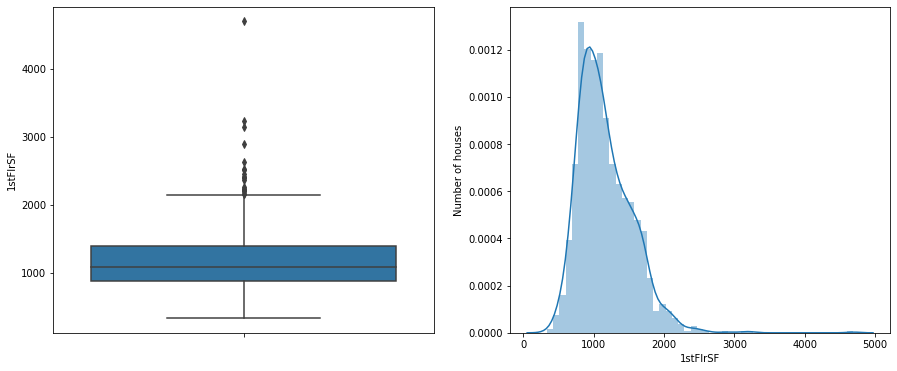

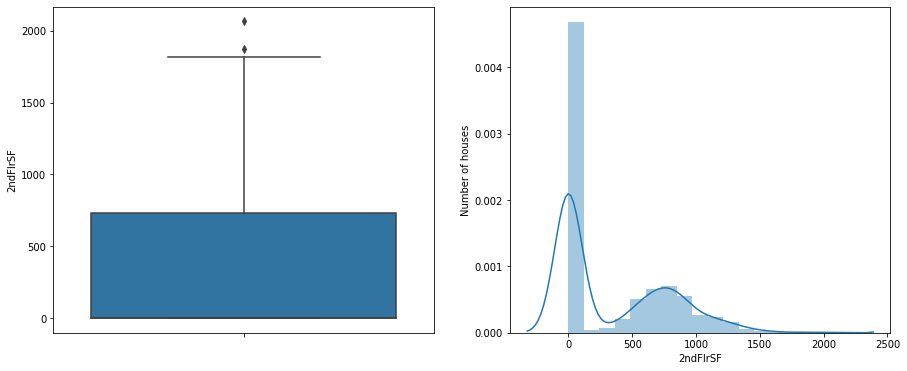

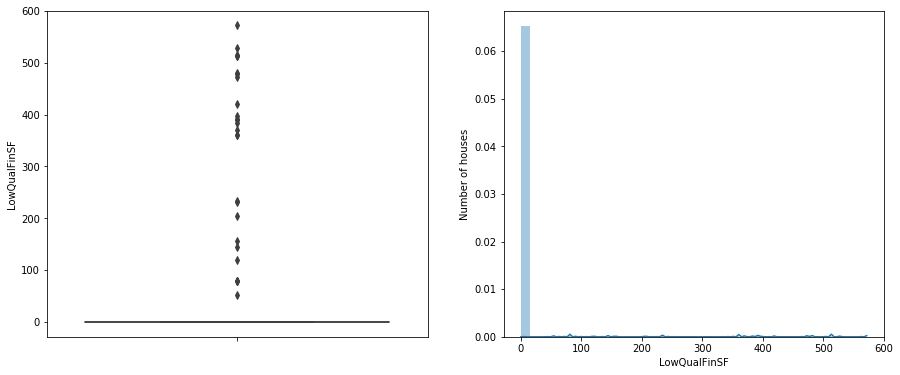

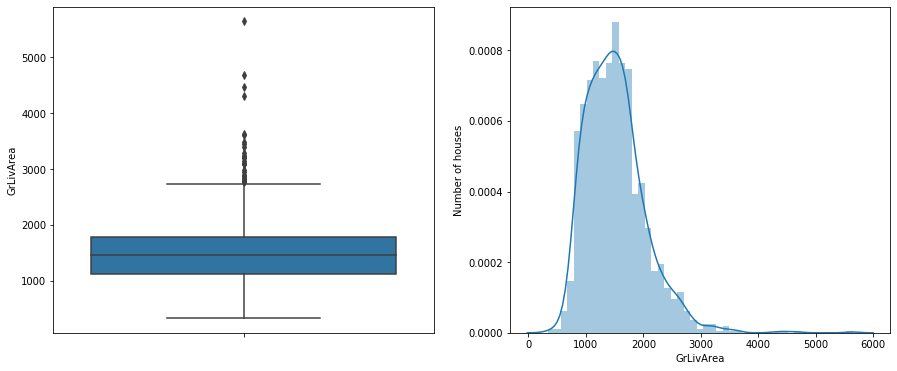

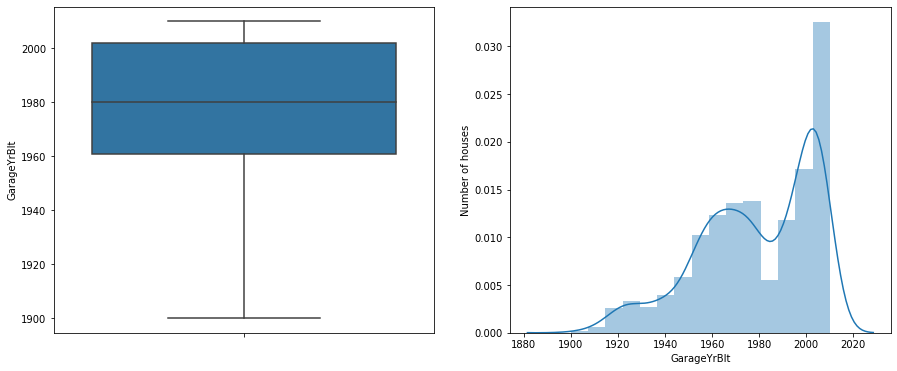

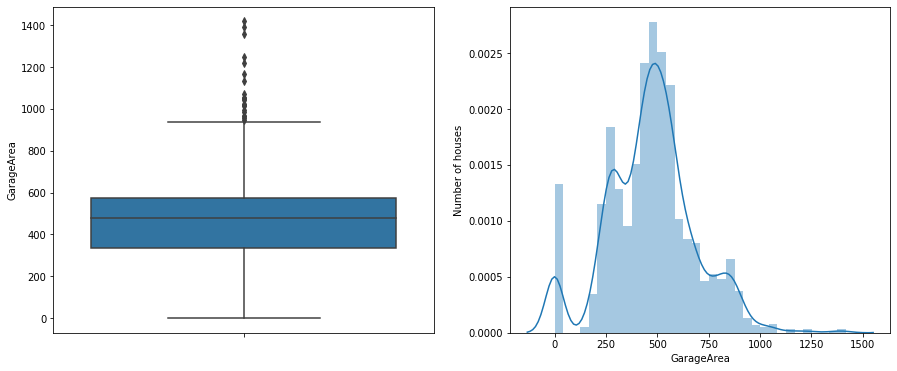

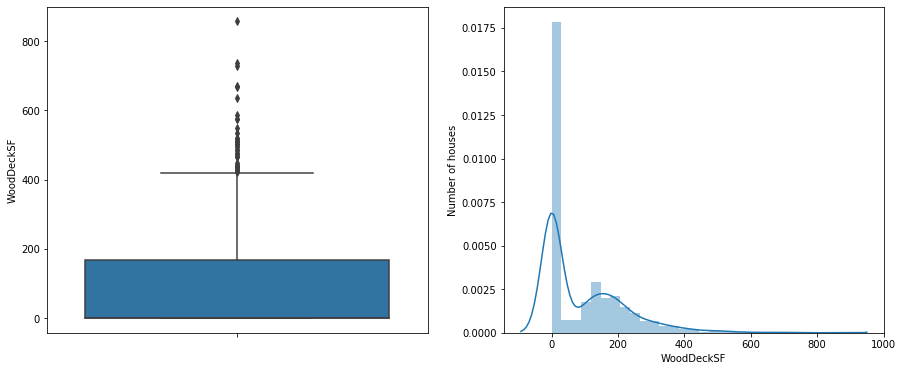

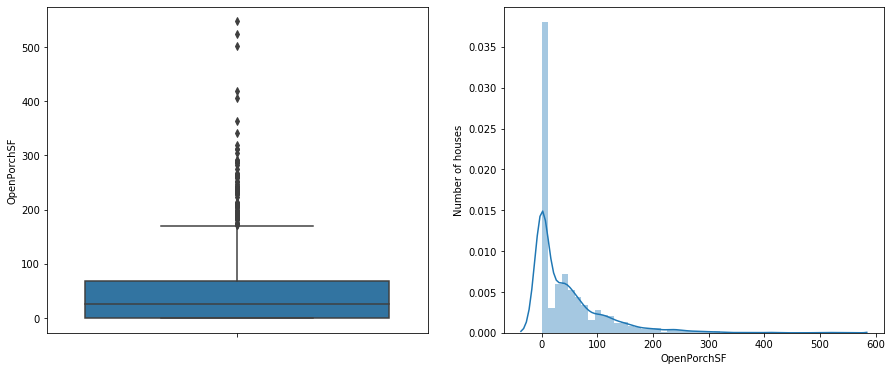

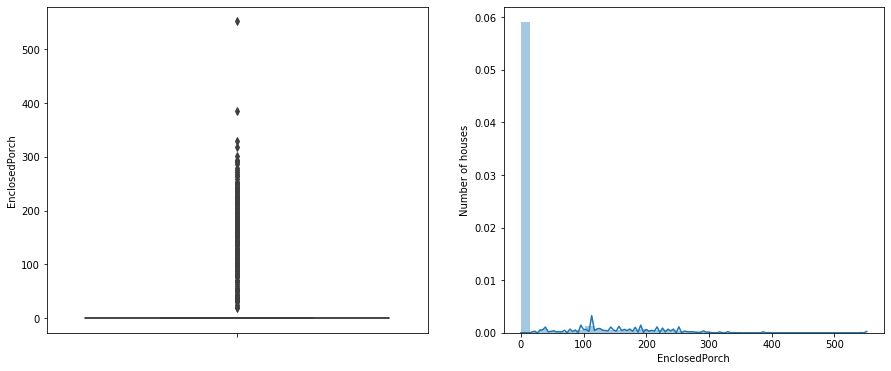

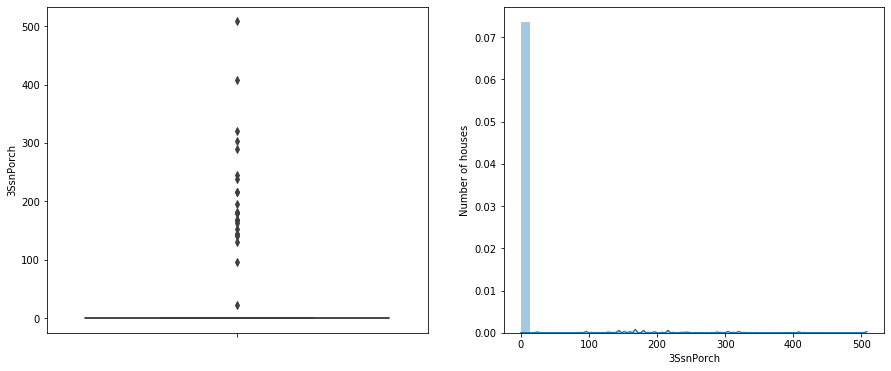

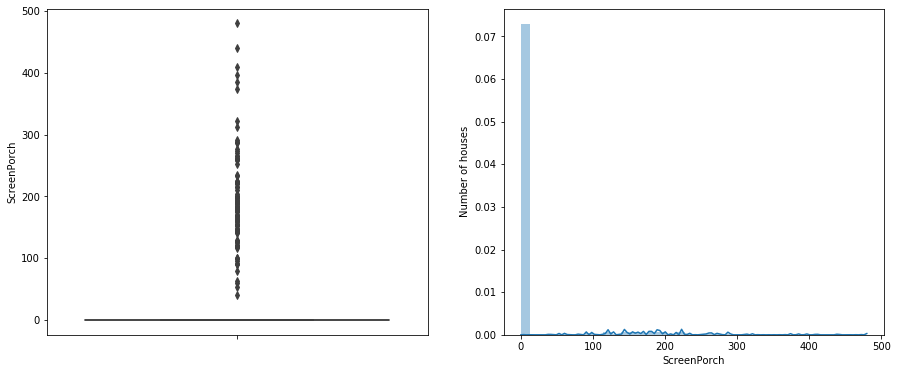

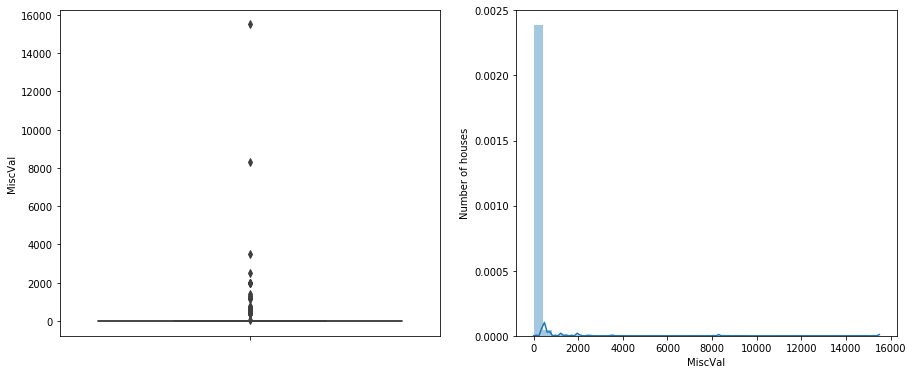

In [10]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=X[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(X[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

Outliers can be visualised as the dots outside the whiskers in the boxplots. The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. If we are planning to build linear regression, we should tackle these to improve the model performance. I will transform the variables with a box cox to try and make them more "Gaussian" looking later on in the notebook. I will not cover outlier removal in the notebook though.

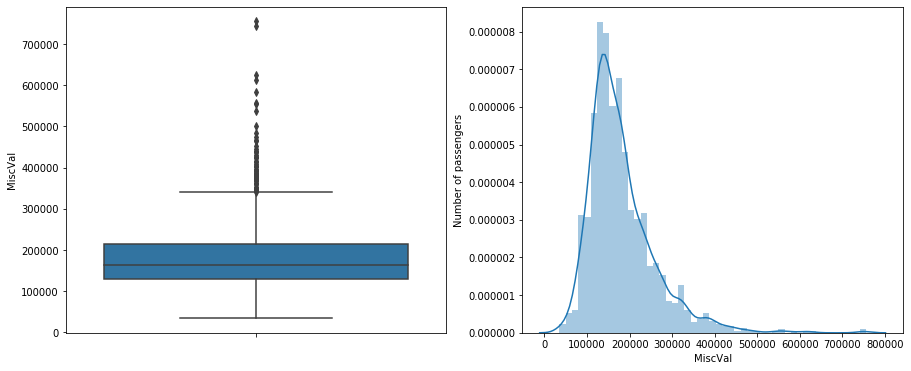

In [11]:
# let's look at the distribution of the target variable

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=X['SalePrice'])
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(X['SalePrice'].dropna())#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

The target variable is also skewed. So I will transform it as well to boost the performance of the algorithm.

<b>Outliers in discrete variables </b>
Let's calculate the percentage of houses for each of the values that can take the discrete variables. I will call outliers, those values that are present in less than 1% of the houses.

In [12]:
# outliers in discrete variables
for var in discrete:
    print(X[var].value_counts() / np.float(len(X)))
    print()

20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64

5     0.271918
6     0.256164
7     0.218493
8     0.115068
4     0.079452
9     0.029452
3     0.013699
10    0.012329
2     0.002055
1     0.001370
Name: OverallQual, dtype: float64

5    0.562329
6    0.172603
7    0.140411
8    0.049315
4    0.039041
3    0.017123
9    0.015068
2    0.003425
1    0.000685
Name: OverallCond, dtype: float64

0    0.586301
1    0.402740
2    0.010274
3    0.000685
Name: BsmtFullBath, dtype: float64

0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64

2    0.526027
1    0.445205
3    0.022603
0    0.006164
Name: FullBath, dtype: float64

0    0.625342
1    0.366438
2    0.008219
Name: HalfBath, dtype: float64

3    0.550685
2    0.245205
4    0.145890
1    0

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset. For linear regression, this may not be a problem, but it most likely will be for tree methods. We should take this into account to improve the performance of our trees.

<b>Number of labels: cardinality</b>
Let's now check if our categorical variables have a huge number of categories. This may be a problem for some machine learning models.

In [13]:
for var in categorical:
    print(var, ' contains ', len(X[var].unique()), ' labels')

MSZoning  contains  5  labels
Street  contains  2  labels
Alley  contains  3  labels
LotShape  contains  4  labels
LandContour  contains  4  labels
Utilities  contains  2  labels
LotConfig  contains  5  labels
LandSlope  contains  3  labels
Neighborhood  contains  25  labels
Condition1  contains  9  labels
Condition2  contains  8  labels
BldgType  contains  5  labels
HouseStyle  contains  8  labels
RoofStyle  contains  6  labels
RoofMatl  contains  8  labels
Exterior1st  contains  15  labels
Exterior2nd  contains  16  labels
MasVnrType  contains  5  labels
ExterQual  contains  4  labels
ExterCond  contains  5  labels
Foundation  contains  6  labels
BsmtQual  contains  5  labels
BsmtCond  contains  5  labels
BsmtExposure  contains  5  labels
BsmtFinType1  contains  7  labels
BsmtFinType2  contains  7  labels
Heating  contains  6  labels
HeatingQC  contains  5  labels
CentralAir  contains  2  labels
Electrical  contains  6  labels
KitchenQual  contains  4  labels
Functional  contains  7 

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Variables with high cardinality may affect the performance of some machine learning models, for example trees.

## Split train data

In [14]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, X.SalePrice, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
#low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
#                        X_train_full[cname].dtype == "object"]

# Select numeric columns
#numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
#my_cols = low_cardinality_cols + numeric_cols
#X_train = X_train_full[my_cols].copy()
#X_valid = X_valid_full[my_cols].copy()
#X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
#X_train = pd.get_dummies(X_train)
#X_valid = pd.get_dummies(X_valid)
#X_test = pd.get_dummies(X_test)
#X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
#X_train, X_test = X_train.align(X_test, join='left', axis=1)

## Feature engineering

Continuous data

In [15]:
# print variables with missing data
for col in continuous:
    if X_train_full[col].isnull().mean()>0:
        print(col, X_train_full[col].isnull().mean())

LotFrontage 0.1815068493150685
MasVnrArea 0.005136986301369863
GarageYrBlt 0.04965753424657534


<b>LotFrontage</b> and <b>GarageYrBlt</b> contain a relatively high percentage of missing values, therefore I will create and additional variable to indicate NA, and then I will do median imputation on the original variable.

<b>MasVnrArea</b> contains a small percentage of missing values, thus I will just do median imputation

In [16]:
# add variable indicating missingness + median imputation
for df in [X_train_full, X_valid_full, X_test_full]:
    for var in ['LotFrontage', 'GarageYrBlt']:
        df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
        df[var].fillna(X_train_full[var].median(), inplace=True) 

for df in [X_train_full, X_valid_full, X_test_full]:
    df.MasVnrArea.fillna(X_train_full.MasVnrArea.median(), inplace=True)

C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Discrete data

In [17]:
# print variables with missing data
for col in discrete:
    if X_train_full[col].isnull().mean()>0:
        print(col, X_train_full[col].isnull().mean())

There is no missing data in the discrete variables. Good, then we don't have to engineer them.

Categorical data

In [18]:
# print variables with missing data
for col in categorical:
    if X_train_full[col].isnull().mean()>0:
        print(col, X_train_full[col].isnull().mean())

Alley 0.9392123287671232
MasVnrType 0.005136986301369863
BsmtQual 0.023972602739726026
BsmtCond 0.023972602739726026
BsmtExposure 0.023972602739726026
BsmtFinType1 0.023972602739726026
BsmtFinType2 0.02482876712328767
Electrical 0.0008561643835616438
FireplaceQu 0.4717465753424658
GarageType 0.04965753424657534
GarageFinish 0.04965753424657534
GarageQual 0.04965753424657534
GarageCond 0.04965753424657534
PoolQC 0.9965753424657534
Fence 0.8167808219178082
MiscFeature 0.9580479452054794


I will add a 'Missing' Label to all of them. If the missing data are rare, I will handle those together with rare labels in a subsequent engineering step.

In [19]:
# add label indicating 'Missing' to categorical variables
for df in [X_train_full, X_valid_full, X_test_full]:
    for var in categorical:
        df[var].fillna('Missing', inplace=True)

In [20]:
# check absence of null values
for var in X_train_full.columns:
    if X_train_full[var].isnull().sum()>0:
        print(var, X_train_full[var].isnull().sum())

In [21]:
# check absence of null values
for var in X_valid_full.columns:
    if X_valid_full[var].isnull().sum()>0:
        print(var, X_valid_full[var].isnull().sum())

In [22]:
test_vars = []
for var in X_train_full.columns:
    if var!='SalePrice' and X_test_full[var].isnull().sum()>0:
        print(var, X_test_full[var].isnull().sum())
        test_vars.append(var)

BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageCars 1
GarageArea 1


This is something important. There are variables in the submission dataset that contain null values (missing data), where in the training set they did not. This needs to be taken into consideration at the time of making predictions, or deploying models in business scenarios.

In [23]:
#  I will replace NAN by the median 
for var in test_vars:
    X_test_full[var].fillna(X_train_full[var].median(), inplace=True)

<b>Transformation of Numerical variables</b>

As most variables were skewed, I will transform them with the box cox transformation.

In [24]:
def boxcox_transformation(var):
    X_train_full[var], param = stats.boxcox(X_train_full[var]+1) 
    X_valid_full[var], param = stats.boxcox(X_valid_full[var]+1) 
    X_test_full[var], param = stats.boxcox(X_test_full[var]+1) 

In [25]:
for var in continuous:
    boxcox_transformation(var)
    
X_train_full[continuous].head()

C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered i

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
Id,,,,,,,,,,,,,,,,,,,,,
619,17.923317,9.874668,6.843349e+70,2.086417e+129,3.049801,6.231707,0.0,72.117848,495.850351,7.585317,...,0.0,9.643829,7.043843e+92,285.045723,0.000000,4.880037,0.000000,0.0,0.404898,0.0
871,14.220455,9.241645,4.170251e+70,8.496116e+128,0.000000,0.000000,0.0,51.451687,280.785318,6.857205,...,0.0,8.514203,3.687668e+92,133.391173,0.000000,0.000000,0.000000,0.0,0.000000,0.0
93,16.765758,10.022651,2.629293e+70,2.045624e+129,0.000000,15.082413,0.0,21.751874,276.257124,6.933858,...,0.0,8.630806,2.018412e+92,176.329005,0.000000,0.000000,0.724202,0.0,0.000000,0.0
818,15.409265,10.014716,6.480482e+70,1.890087e+129,2.789425,17.584776,0.0,32.178529,439.843394,7.504727,...,0.0,9.516345,6.559847e+92,309.970775,4.006493,4.237583,0.000000,0.0,0.000000,0.0
303,20.871015,10.050923,6.410147e+70,1.890087e+129,2.793018,0.000000,0.0,67.303290,433.785653,7.411302,...,0.0,9.369332,6.466977e+92,305.798023,4.679882,4.572940,0.000000,0.0,0.000000,0.0


In [26]:
# let's  check if the transformation created infinite values
for var in continuous:
    if np.isinf(X_train_full[var]).sum()>1:
        print(var)

In [27]:
for var in continuous:
    if np.isinf(X_valid_full[var]).sum()>1:
        print(var)

In [28]:
for var in continuous:
    if np.isinf(X_test_full[var]).sum()>1:
        print(var)

In [29]:
# check absence of null values(there should be none)
for var in X_train_full.columns:
    if X_valid_full[var].isnull().sum()>0:
        print(var, X_valid_full[var].isnull().sum())

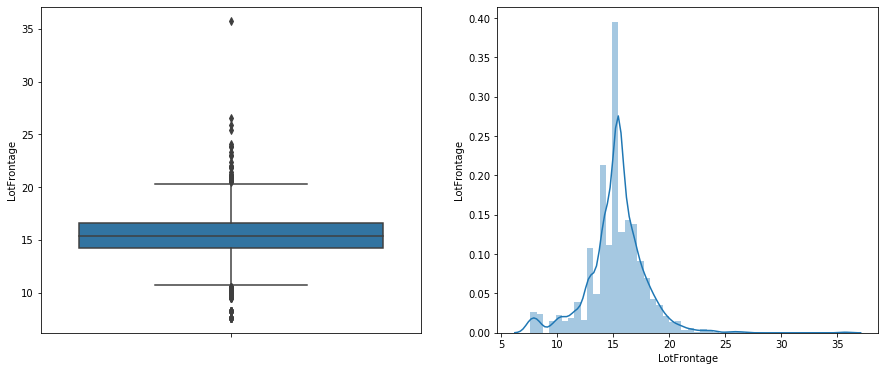

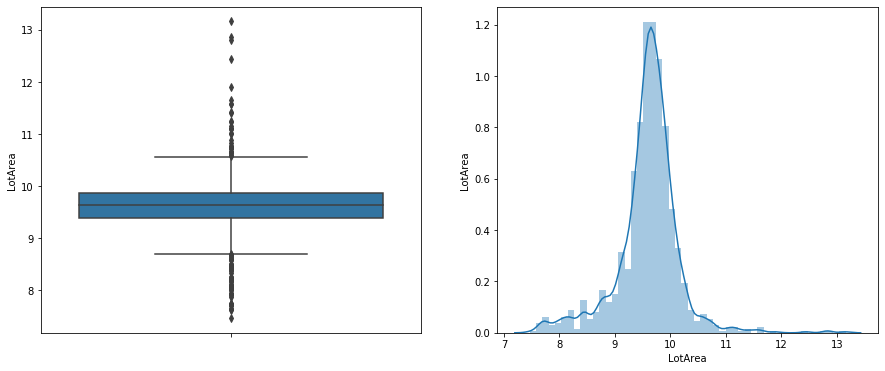

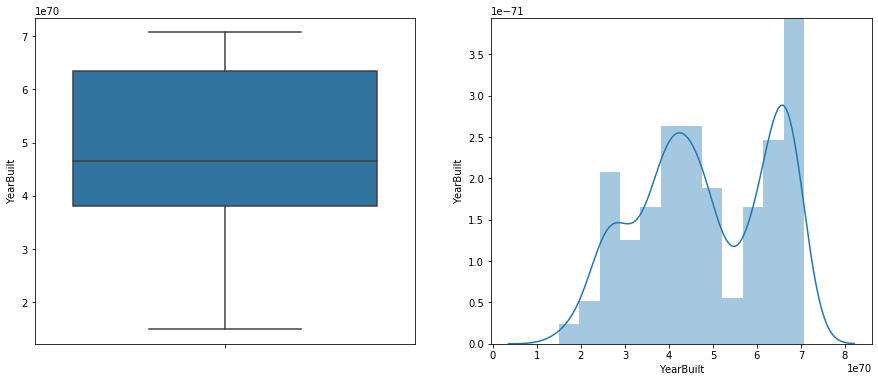

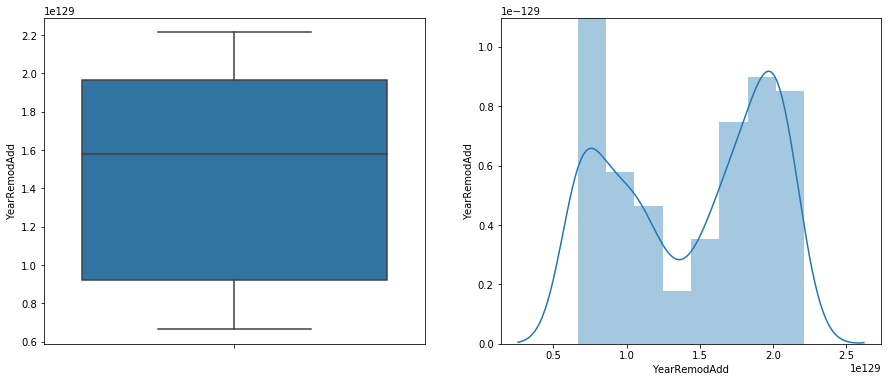

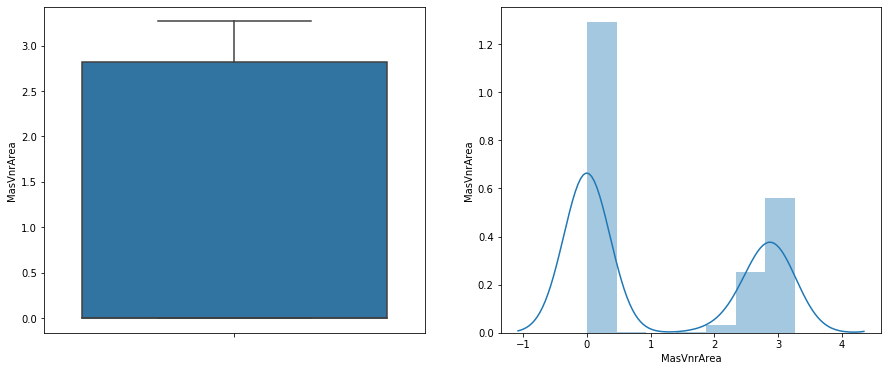

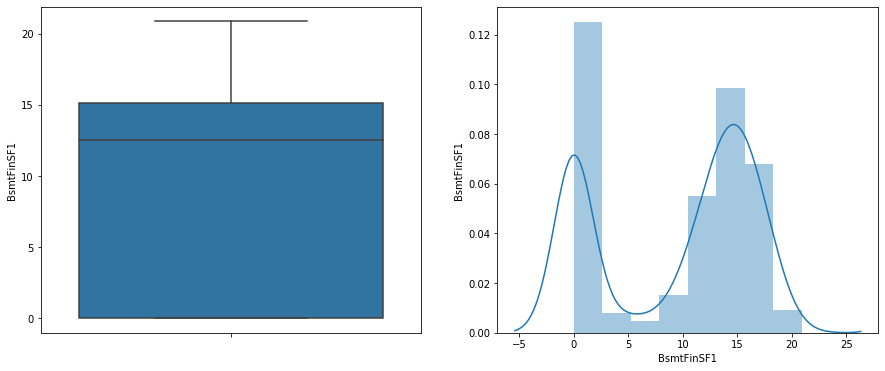

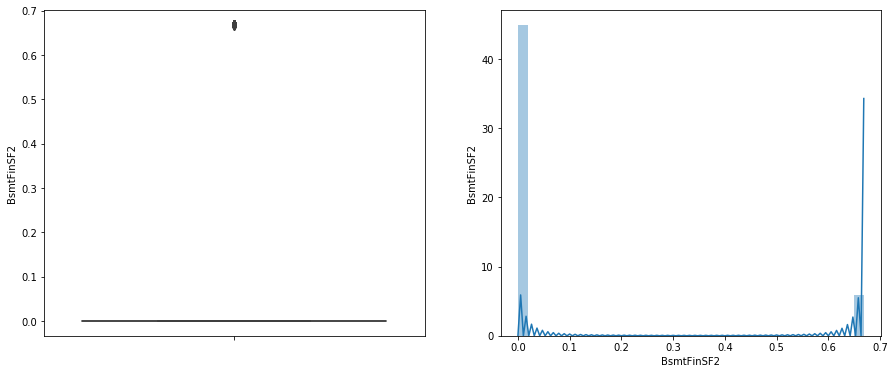

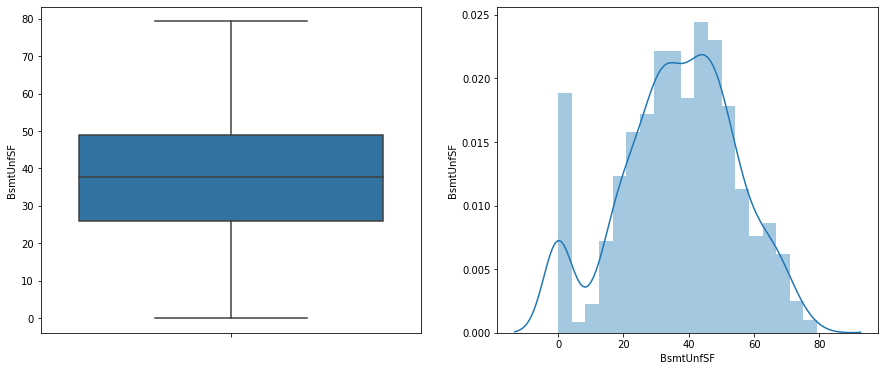

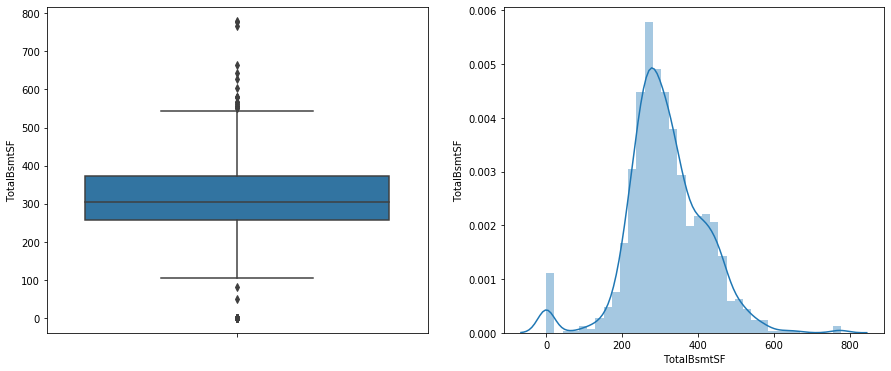

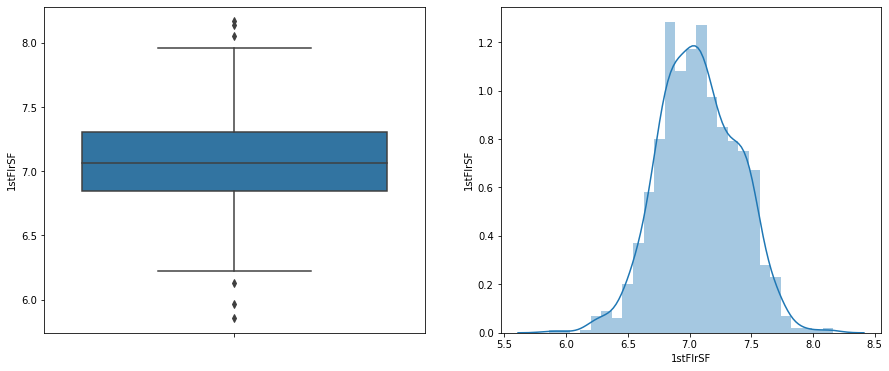

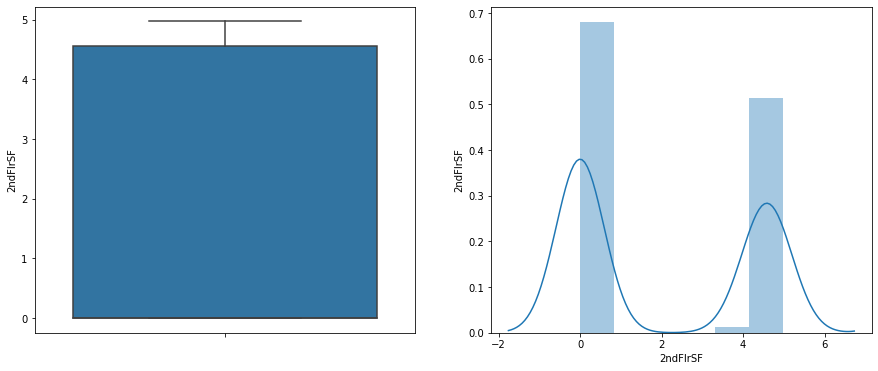

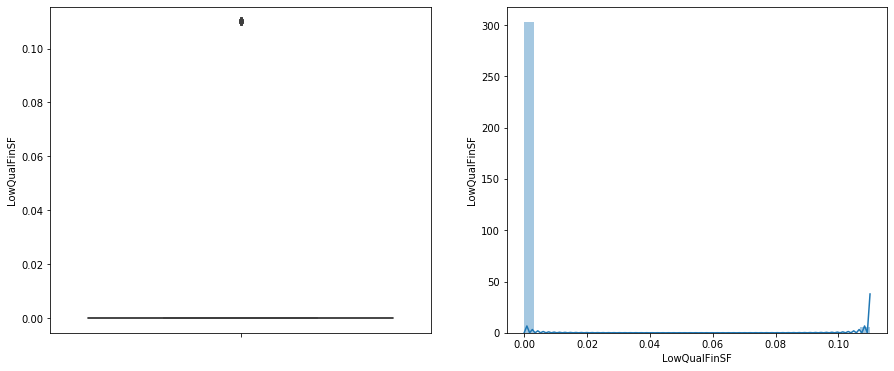

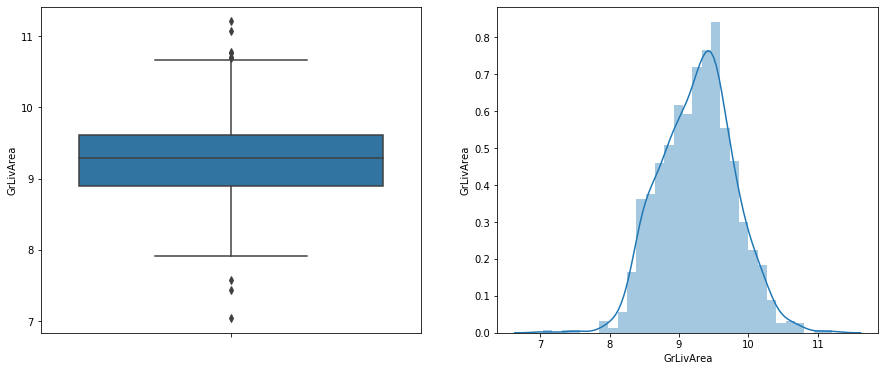

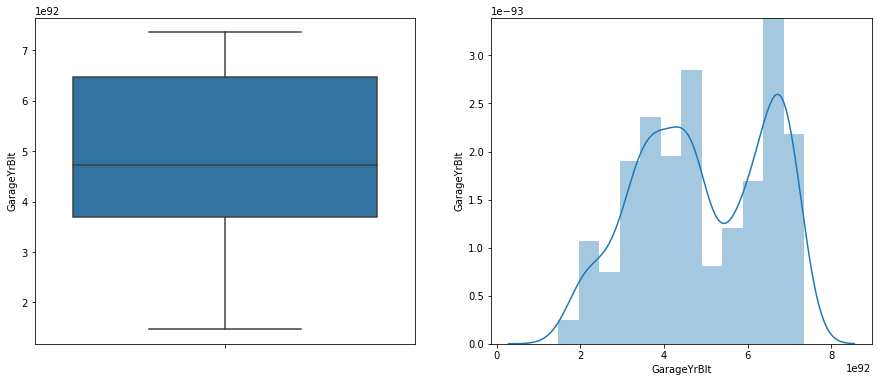

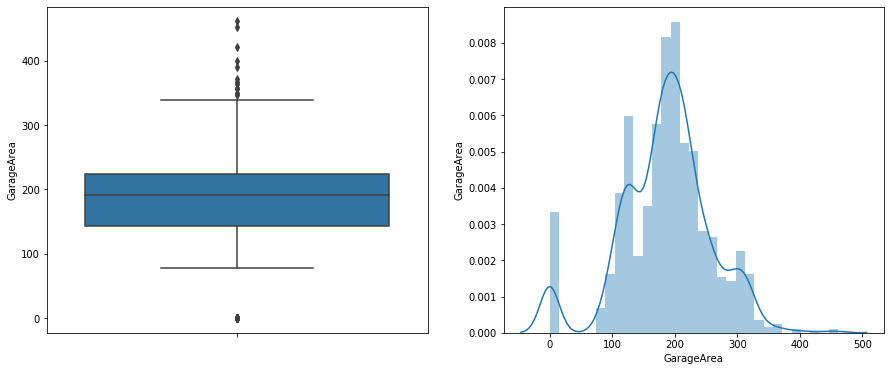

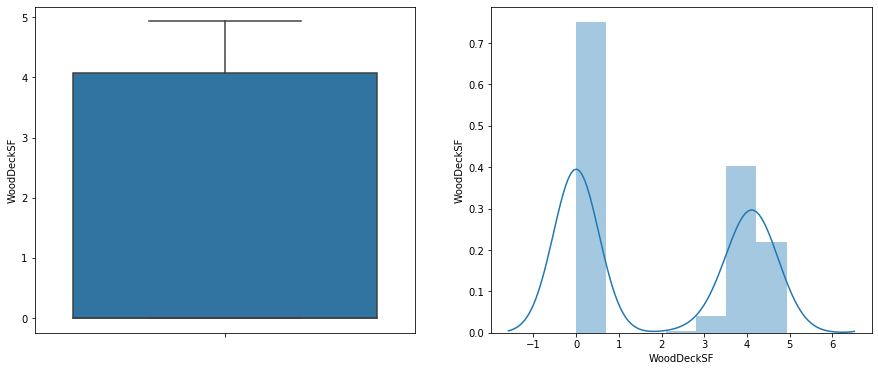

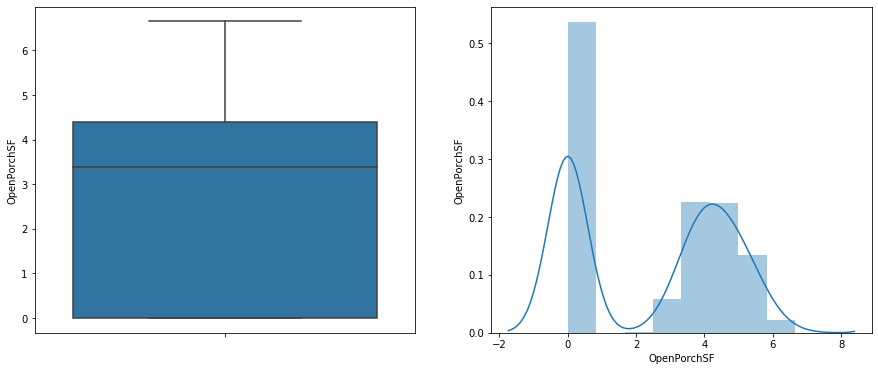

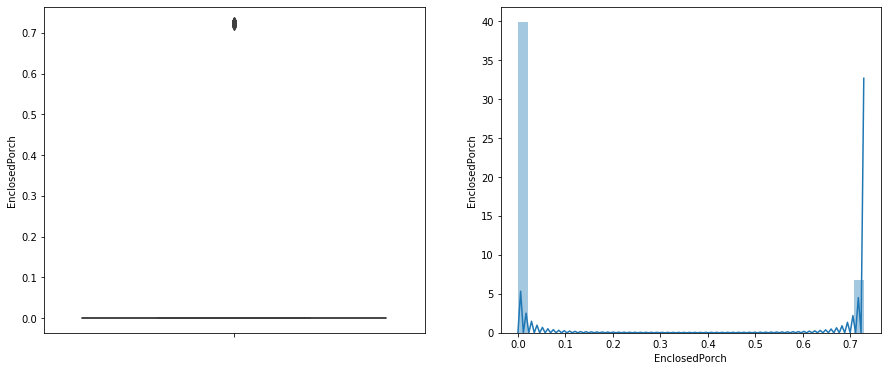

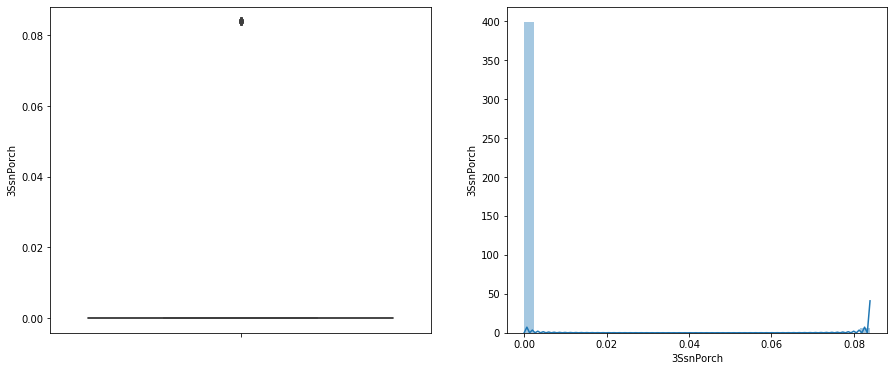

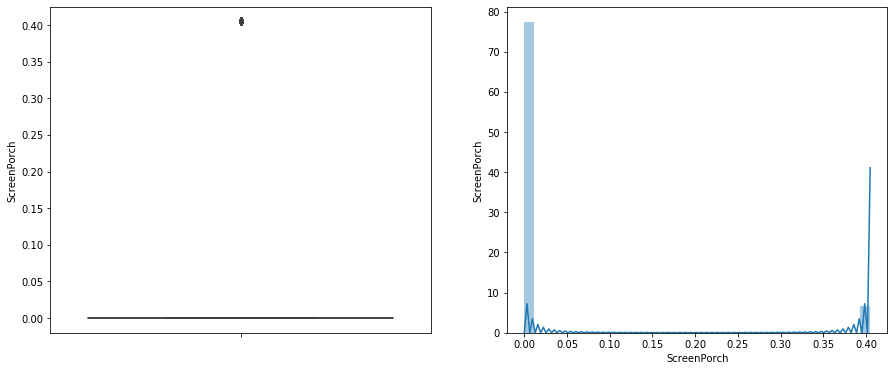

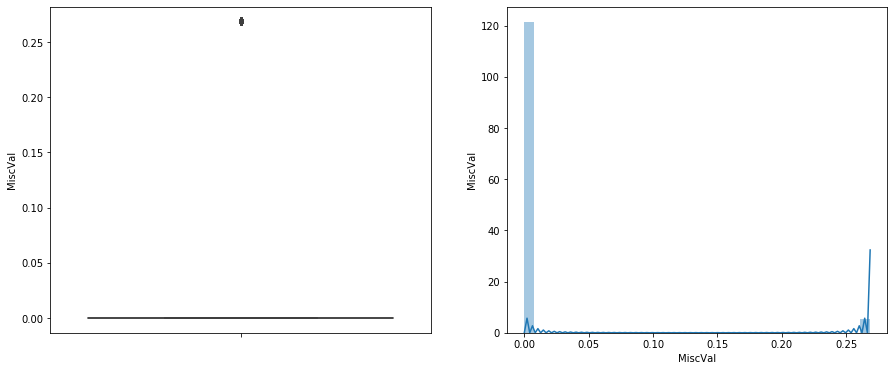

In [30]:
# let's make boxplots to visualise outliers in the continuous variables
# and histograms to get an idea of the distribution
# hopefully the transformation yielded variables more "Gaussian"looking


for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=X_train_full[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(X_train_full[var].dropna())#.hist(bins=20)
    fig.set_ylabel(var)
    fig.set_xlabel(var)

    plt.show()

The boxcox transformation worked for some of the variables, and of course it did not for some others. Those for example where only one value was predominant could not be shaped into a Gaussian looking distribution.

Also, notice that there are still outliers in several of the variables. Ideally, we would like to remove them somehow.

<b>Normalization of target variable</b>

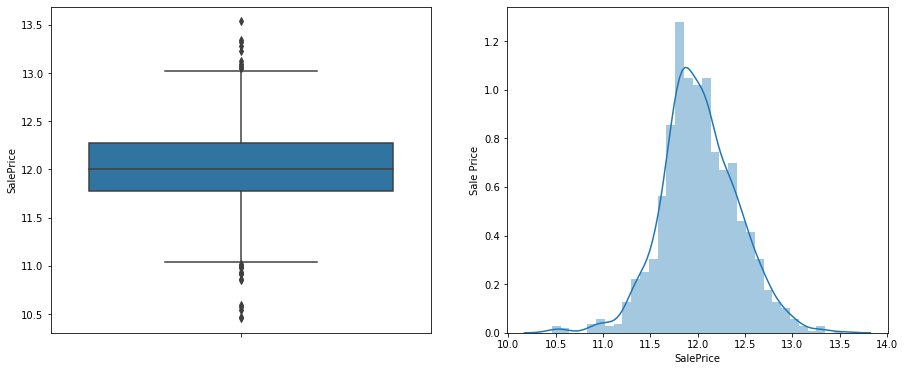

In [31]:
var = 'SalePrice'
y_train = np.log(y_train) 
y_valid = np.log(y_valid) 

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(y_train)#.hist(bins=20)
fig.set_ylabel('Sale Price')
fig.set_xlabel(var)

plt.show()

The transformation of the Sale Variable worked quite well. It shows not a more Gaussian looking shape.

Engineering rare labels in categorical and discrete variables

In [32]:
def rare_imputation(variable):
    # find frequent labels / discrete numbers
    temp = X_train_full.groupby([variable])[variable].count()/np.float(len(X_train_full))
    frequent_cat = [x for x in temp.loc[temp>0.03].index.values]
    
    X_train_full[variable] = np.where(X_train_full[variable].isin(frequent_cat), X_train_full[variable], 'Rare')
    X_valid_full[variable] = np.where(X_valid_full[variable].isin(frequent_cat), X_valid_full[variable], 'Rare')
    X_test_full[variable] = np.where(X_test_full[variable].isin(frequent_cat), X_test_full[variable], 'Rare')
    
# find unfrequent labels in categorical variables
for var in categorical:
    rare_imputation(var)
    
for var in ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']:
    X_test_full[var] = X_test_full[var].astype('int')

C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<b>Apply encoding to categorical variables</b>

In [33]:
#def encode_categorical_variables(var, target):
#        # make label to house price dictionary
#        ordered_labels = X_train_full.groupby([var])[target].mean().sort_values().index
#        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
#        
#        # encode variables
#        X_train_full[var] = X_train_full[var].map(ordinal_label)
#        X_valid_full[var] = X_valid_full[var].map(ordinal_label)
#        X_test_full[var] = X_test_full[var].map(ordinal_label)
#
## encode labels in categorical vars
#for var in categorical:
#    encode_categorical_variables(var, 'SalePrice')

In [34]:
training_vars = [var for var in X_train_full.columns if var not in ['Id', 'SalePrice']]

In [35]:
X_train = pd.get_dummies(X_train_full)
X_valid = pd.get_dummies(X_valid_full)
X_test = pd.get_dummies(X_test_full)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [36]:
# Print training dataset
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,MiscFeature_Missing,MiscFeature_Rare,MiscFeature_Shed,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare
Id,,,,,,,,,,,,,,,,,,,,,
619,20,17.923317,9.874668,9,5,6.843349e+70,2.086417e+129,3.049801,6.231707,0.0,...,1,0,0,1,0,0,0,0,1,0
871,20,14.220455,9.241645,5,5,4.170251e+70,8.496116e+128,0.000000,0.000000,0.0,...,1,0,0,0,0,1,0,1,0,0
93,30,16.765758,10.022651,5,7,2.629293e+70,2.045624e+129,0.000000,15.082413,0.0,...,1,0,0,0,0,1,0,1,0,0
818,20,15.409265,10.014716,8,5,6.480482e+70,1.890087e+129,2.789425,17.584776,0.0,...,1,0,0,0,0,1,0,1,0,0
303,20,20.871015,10.050923,7,5,6.410147e+70,1.890087e+129,2.793018,0.000000,0.0,...,1,0,0,0,0,1,0,1,0,0


In [37]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(random_state=0)

# Fit the model
my_model_1.fit(X_train, y_train)

C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:26:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [38]:
from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_1 = np.exp(my_model_1.predict(X_valid))

In [39]:
# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, np.exp(y_valid))
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 2019.034835188348


## Improving the model

In [40]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit the model
my_model_2.fit(X_train, y_train)

# Get predictions
predictions_2 = np.exp(my_model_2.predict(X_valid))

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, np.exp(y_valid))
print("Mean Absolute Error:" , mae_2)

[00:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error: 1136.9847763270504


In [41]:
# Define the model
my_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

# Fit the model
my_model_3.fit(X_train, y_train, 
               early_stopping_rounds=5, 
               eval_set=[(X_valid, y_valid)], 
               verbose=False)

# Get predictions
predictions_3 = np.exp(my_model_3.predict(X_valid))

# Calculate MAE
mae_3 = mean_absolute_error(predictions_3, np.exp(y_valid))

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_3)

[00:26:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error: 1080.5048159246548


In [42]:
# Define the model
my_model_4 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

# Fit the model
my_model_4.fit(X_train, y_train,
              early_stopping_rounds=15,
              eval_set=[(X_valid, y_valid)], 
              verbose=False)

# Get predictions
predictions_4 = np.exp(my_model_4.predict(X_valid))

# Calculate MAE
mae_4 = mean_absolute_error(predictions_4, np.exp(y_valid))
print("Mean Absolute Error:" , mae_4)

[00:26:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\pedro.allegro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error: 1081.1912189640384


In [43]:
predictions_4[0:10]

array([201641.14, 132978.17, 110452.41, 190392.17,  88241.25,  85036.17,
       283403.1 , 140482.81, 654552.75, 148863.03], dtype=float32)

In [45]:
np.exp(y_valid[0:10])

Id
530     200624.0
492     133000.0
460     110000.0
280     192000.0
656      88000.0
1014     85000.0
1404    282922.0
602     141000.0
1183    745000.0
688     148800.0
Name: SalePrice, dtype: float64